In [1]:
import jsonlines
import os
import json
import glob
import numpy as np
import pathlib
from numpy import load
import torch
import lovely_tensors as lt
lt.monkey_patch()
import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
from PIL import Image


/scratch/bbki/kastanday/conda_envs/envs/v4_clip_preprocessing_yt1b/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Instantiate clip
import clip

MODEL_SIZE = 'ViT-L/14@336px'  # Best models are (1st) ViT-L/14@336px and (2nd) ViT-L/14. I don't recommend going lower.  
clip_instance, clip_preprocess = clip.load(MODEL_SIZE, device)


In [3]:
# T5
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Model, T5Config, AutoModelWithLMHead

'''
MODEL SELECTION

T5 V1.1 --  https://huggingface.co/docs/transformers/model_doc/t5v1.1 && https://github.com/google-research/text-to-text-transfer-transformer/blob/main/released_checkpoints.md#t511
small - base - large - 3b/xl - 11b/xxl

OG: t5-small

'google/t5-base-lm-adapt' # largest on my server (without float16)
'google/t5-xl-lm-adapt'

google/t5-v1_1-large
'''

# MODEL_SIZE = "t5-base"
MODEL_NAME = "google/t5-v1_1-base"
# MODEL_NAME = "google/t5-base-lm-adapt"
# config = T5Config.from_pretrained(MODEL_NAME)
t5 = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, torch_dtype=torch.float32, low_cpu_mem_usage=False).to(device) # float16, True
t5_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, return_special_tokens_mask=True)
# low_cpu_mem_usage(bool, optional) — Tries to not use more than 1x model size in CPU memory (including peak memory) while loading the model. experimental.
optimizer = torch.optim.Adam(params =  t5.parameters(), lr=1e-4) # Typically, 1e-4 and 3e-4 work well for most problems


In [ ]:
for param in t5.parameters():
  print(param.dtype)

In [5]:
dir_name = "parallel_15"
# REMOTE_WHISPER_FILE = f'/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/{dir_name}_whisper_output.jsonl'
# REMOTE_CLIP_DIR  = f'/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/{dir_name}_clip_output'
# REMOTE_SCENE_FILE = f'/mnt/storage_hdd/thesis/yt_1b_dataset/yt_1b_train/{dir_name}_scene_output.jsonl'

# DELTA 
REMOTE_WHISPER_FILE = f'/scratch/bbki/kastanday/whisperr/{dir_name}_whisper_output.jsonl'
REMOTE_CLIP_DIR     = f'/scratch/bbki/kastanday/whisper/{dir_name}_clip_output'
REMOTE_SCENE_FILE   = f'/scratch/bbki/kastanday/whisper/{dir_name}_scene_output.jsonl'


0it [00:00, ?it/s]

THE MOST IMPORTANT THING THAT FOUNTAIN VIEWS' VOCATIONAL PROGRAM HAS TAUGHT ME WOULD PROBABLY BE
book on shelf, person in front of shelf, person in front of door-stuff, person wearing tie, door-stuff beside person, book beside shelf, door-stuff beside shelf, shelf beside person
(1, 336, 336, 3)


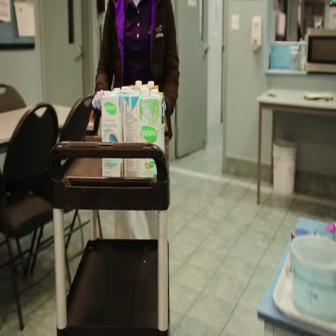



before
tensor[1, 40] i64 x∈[1, 27986] μ=8.050e+03 σ=8.607e+03
tensor([[ 1853,   283, 14464,     3,  5166, 14536,  9156,     3,  4611,  2365,
         16662, 12408, 17161, 13570,     3, 27633,   134,    31,     3,  8040,
         18911, 27342,  6828,   517, 23203,   454,  3291,     3,  3221, 19046,
         10966,  7934,   549, 27986,  6828,  4882,   279,  5121,  6554,     1]])
after
tensor[1, 40] i64 x∈[1, 27986] μ=8.050e+03 σ=8.607e+03
tensor([[ 1853,   283, 14464,     3,  5166, 14536,  9156,     3,  4611,  2365,
         16662, 12408, 17161, 13570,     3, 27633,   134,    31,     3,  8040,
         18911, 27342,  6828,   517, 23203,   454,  3291,     3,  3221, 19046,
         10966,  7934,   549, 27986,  6828,  4882,   279,  5121,  6554,     1]])


0it [00:02, ?it/s]


KeyboardInterrupt: 

In [8]:
import yappi
yappi.set_clock_type("cpu") # Use set_clock_type("wall") for wall time
yappi.start()


# Iterate through the batch
clip_15 = os.listdir(REMOTE_CLIP_DIR)

# Initialize embeddings
one_input_shape = [1, 768, 768]
att_mask_shape = [1, 768]
embed_shape = [1, 768]

input_embeds_arr = torch.zeros(one_input_shape).to(device) # .astype(np.float16)
attn_mask_arr    = torch.zeros(att_mask_shape).to(device)
attn_mask_arr[0][0] = 1
attn_mask_arr[0][1] = 1
attn_mask_arr[0][2] = 1

t5.train()

with jsonlines.open(REMOTE_SCENE_FILE, 'r') as scene_reader:
    # Zipping the scene graph with the clip + whisper embeddings
    
    # itr over videos
    for scene_seg_list, clip_npz_path in tqdm.tqdm(zip(scene_reader, glob.glob(os.path.join(REMOTE_CLIP_DIR, '*'), recursive = True))):
        try:
            np_loaded = np.load(clip_npz_path, allow_pickle=True)
        except Exception as e:
            print(f"Failed to load compressed numpy: {e}")
            continue
        object_list_of_str = []
        scene_seg_list = json.loads(scene_seg_list)
        
        # iterate over segments
        for segment_index in range(np_loaded['arr_0'].item()['total_segments']):
            # print(np_loaded[f'arr_{segment_index}'].item()['captions'])
            frame_embedding       = np_loaded[f'arr_{segment_index}'].item()['frame_embeddings']
            caption_embedding     = np_loaded[f'arr_{segment_index}'].item()['text_caption_embeddings']
            whisper_text_captions = np_loaded[f'arr_{segment_index}'].item()['captions']
            
            frame_embedding       = torch.from_numpy(frame_embedding.reshape((768,))).to(device)
            caption_embedding     = torch.from_numpy(caption_embedding).to(device)

            # printing inputs
            print(whisper_text_captions)         # whisper caption -- label
            print(scene_seg_list[segment_index]) # scene graph of segment
            
            print(np_loaded[f'arr_{segment_index}'].item()['segment_frames'].shape)
            
            img_frame_array = np_loaded[f'arr_{segment_index}'].item()['segment_frames'].reshape(336, 336, 3)
            img_frame = Image.fromarray(img_frame_array)
            display(img_frame)
            print('\n')
            
            scene_caption = scene_seg_list[segment_index]
            scene_caption = clip.tokenize(scene_caption).to(device)
            with torch.inference_mode(): # even faster than no_grad()
                scene_embedding = clip_instance.encode_text(scene_caption)
            scene_embedding = scene_embedding.reshape((768,))

            # Update embedding array
            input_embeds_arr[0][0] = frame_embedding
            input_embeds_arr[0][1] = caption_embedding
            input_embeds_arr[0][2] = scene_embedding
            # Set to torch
            decoder_input_embeds_arr = np.random.rand( *one_input_shape )  # .astype(np.float16) # need fp32
            decoder_input_embeds_arr = decoder_input_embeds_arr
            input_embeds_arr = input_embeds_arr
            attn_mask_arr = attn_mask_arr
            
            
            ''' forwards pass '''
            labels = t5_tokenizer(whisper_text_captions, return_tensors="pt").input_ids.to(device)
            print("before")
            print(labels.v)
            labels[labels == t5_tokenizer.pad_token_id] = -100
            print("after")
            print(labels.v)
            
            outputs = t5.forward(inputs_embeds=input_embeds_arr, attention_mask=attn_mask_arr, labels=labels)
            loss = outputs[0]
            ''' backwards pass '''
            optimizer.zero_grad()
            loss.sum().backward()
            optimizer.step()
            
            for param in t5.parameters():
                print(param.dtype)
                
            # yappi.get_func_stats().print_all()
            # yappi.get_thread_stats().print_all()


In [ ]:
t5.save_pretrained("BIG_PENIS_PREVAILS")

# Trying Inference with custom model

import jsonlines
import os
import json
import glob
import numpy as np
import pathlib
from numpy import load
import lovely_tensors as lt
lt.monkey_patch()
import tqdm

import jsonlines
import os
import json
import glob
import numpy as np
import pathlib
from numpy import load
import lovely_tensors as lt
lt.monkey_patch()
import tqdm

In [1]:
import jsonlines
import os
import json
import glob
import numpy as np
import pathlib
import torch
import lovely_tensors as lt
lt.monkey_patch()
import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

/scratch/bbki/kastanday/conda_envs/envs/v4_clip_preprocessing_yt1b/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# T5
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Model, T5Config, AutoModelWithLMHead

'''
MODEL SELECTION

T5 V1.1 --  https://huggingface.co/docs/transformers/model_doc/t5v1.1 && https://github.com/google-research/text-to-text-transfer-transformer/blob/main/released_checkpoints.md#t511
low_cpu_mem_usage(bool, optional) — Tries to not use more than 1x model size in CPU memory (including peak memory) while loading the model. experimental.
small - base - large - 3b/xl - 11b/xxl

OG: t5-small

'google/t5-base-lm-adapt' # largest on my server (without float16)
'google/t5-xl-lm-adapt'

google/t5-v1_1-large
'''

# MODEL_SIZE = "t5-base"
# MODEL_NAME = "google/t5-base-lm-adapt"

MODEL_NAME = "google/t5-v1_1-base"
OUR_FINETUNED_MODEL = "v1_VPT_model"
t5 = T5ForConditionalGeneration.from_pretrained(OUR_FINETUNED_MODEL).to(device) # float16, True
t5_tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, return_special_tokens_mask=True)

In [18]:


PROMPT = "This guy has a really"
# PROMPT = "In today's video we're going to see"
# PROMPT = "Hey guys, welcome back"
# PROMPT = "I really love drugs drugs are the"
PROMPT = "FUCK YOU I HATE YOU"
PROMPT = "PENIS ASS DICK"


# inference
input_ids = t5_tokenizer(PROMPT, return_tensors="pt").input_ids  # Batch size 1
outputs = t5.generate(input_ids)
print(t5_tokenizer.decode(outputs[0], skip_special_tokens=True))

HE'S HE'S HE'S HE'S HE'


In [12]:
outputs[0]

SyntaxError: invalid syntax (2268228266.py, line 1)

In [4]:
# Get the model's parameters
params = t5.parameters()

# Sum the number of elements in each parameter tensor
num_params = sum([p.numel() for p in params])
num_params

247577856

In [ ]:
247_577_856 # 247M. 